## Covid X-Ray Image Data
Cheng Zhong

**Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145**

**Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.**

From the beginning of 2020, coronavirus (COVID-19) has been seriously endangering human beings' lives and health. It is significant to identify patients who are infected. Chest X-ray images have been an important evidence to diagnose positive cases. In this project, the image dataset includes three categories: normal, covid positive, and Viral Pneumonia. By applying convolutional neural network and transfer learning methods, the diagnostic accuracy could be improved. Medical workers, scientists, and policy-makers could advance their analytical judgements and make their best decisions.

In [1]:
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [7]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [3]:
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
To: /content/COVID-19_Radiography_Database.zip
1.22GB [00:05, 215MB/s]
Archive:  COVID-19_Radiography_Database.zip
replace COVID-19 Radiography Database/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: COVID-19 Radiography Database/COVID.metadata.xlsx  
replace COVID-19 Radiography Database/COVID/COVID (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: COVID-19 Radiography Database/COVID/COVID (1).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (10).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (100).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1000).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1001).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1002).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1003).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1004).png 

In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (165).png', 'COVID-19 Radiography Database/COVID/COVID (577).png', 'COVID-19 Radiography Database/COVID/COVID (1067).png', 'COVID-19 Radiography Database/COVID/COVID (840).png', 'COVID-19 Radiography Database/COVID/COVID (879).png', 'COVID-19 Radiography Database/COVID/COVID (692).png', 'COVID-19 Radiography Database/COVID/COVID (919).png', 'COVID-19 Radiography Database/COVID/COVID (487).png', 'COVID-19 Radiography Database/COVID/COVID (761).png', 'COVID-19 Radiography Database/COVID/COVID (378).png', 'COVID-19 Radiography Database/COVID/COVID (679).png', 'COVID-19 Radiography Database/COVID/COVID (119).png', 'COVID-19 Radiography Database/COVID/COVID (842).png', 'COVID-19 Radiography Database/COVID/COVID (1173).png', 'COVID-19 Radiography Database/COVID/COVID (926).png', 'COVID-19 Radiography Database/COVID/COVID (353).png', 'COVID-19 Radiography Database/COVID/COVID (1021).png', 'COVI

In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

(192, 192, 3)

In [8]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [9]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one

3886
(3886, 192, 192, 3)
0.0
1.0


In [10]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


**Visualize images that demonstrate when x-rays demonstrate Covid Postivity and when they do not.**

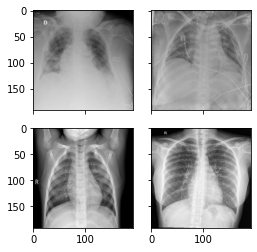

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (100).png')
im2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1024).png')
im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1031).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [12]:
# Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)

y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

### Model 1
- Keras Convolutional Neural Network

In [13]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3108 samples, validate on 778 samples
Epoch 1/5
3108/3108 [==============================] - 203s 65ms/sample - loss: 0.5646 - acc: 0.7561 - val_loss: 0.3880 - val_acc: 0.8728
Epoch 2/5
3108/3108 [==============================] - 197s 64ms/sample - loss: 0.3177 - acc: 0.8845 - val_loss: 0.2319 - val_acc: 0.9229
Epoch 3/5
3108/3108 [==============================] - 200s 64ms/sample - loss: 0.2472 - acc: 0.9102 - val_loss: 0.2027 - val_acc: 0.9254
Epoch 4/5
3108/3108 [==============================] - 210s 67ms/sample - loss: 0.2102 - acc: 0.9212 - val_loss: 0.1708 - val_acc: 0.9357
Epoch 5/5
3108/3108 [==============================] - 202s 65ms/sample - loss: 0.2038 - acc: 0.9266 - val_loss: 0.1640 - val_acc: 0.9460


In [14]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 1 2 0 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 1 2 1 1 1 1 0 2 2 1 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 1 0 1 1 1 2 2 0 2 0 1 2 0 1 0 0 1 0 1 0 2 0 0 0
 0 0 2 2 2 2 2 1 2 1 1 1 1 0 2 2 2 1 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 0 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 2 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 0 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 0 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 1 2 1 2 1 1 1 0 2 0 2 2 2 1 2 2 1 1 0 0 2 0 0 0 1 0 2 2 1 0 2 1 2
 1 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 1 2 1 0 1 2 0 2 2 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 0 2 1 2 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 1 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 0 1 0 2 1 1 2 1 2 0 1 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 1 2 2 1 2 1 2 1 1 2 2 1 1 2 2 0 1 0 2 0 1 2 0 2 2 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [15]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [16]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.946015,0.946158,0.946197,0.946308,0,0,0,0


### Model 2
- second convolutional layer with kernal size = 3
- initiate ReduceLROnPlateau to avoid overfitting

In [18]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Train on 3108 samples, validate on 778 samples
Epoch 1/5
3108/3108 [==============================] - 470s 151ms/sample - loss: 0.5764 - acc: 0.7436 - val_loss: 0.2680 - val_acc: 0.9075
Epoch 2/5
3108/3108 [==============================] - 465s 150ms/sample - loss: 0.2793 - acc: 0.9009 - val_loss: 0.2619 - val_acc: 0.8985
Epoch 3/5
3108/3108 [==============================] - 462s 149ms/sample - loss: 0.2354 - acc: 0.9215 - val_loss: 0.1804 - val_acc: 0.9396
Epoch 4/5
3108/3108 [==============================] - 464s 149ms/sample - loss: 0.1948 - acc: 0.9311 - val_loss: 0.1775 - val_acc: 0.9344
Epoch 5/5
3108/3108 [==============================] - 464s 149ms/sample - loss: 0.1654 - acc: 0.9421 - val_loss: 0.1536 - val_acc: 0.9447


In [19]:
# using predict_classes() for multi-class data to return predicted class index.
prediction_index=predict_classes(model.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object
y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMO

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.94473,0.9453,0.946525,0.94447,0,0,0,0


### Model 3
- Transfer Learning
- Start with pre-established weights and retrain model final output layer to fit new output layer parameters to your data.

In [20]:
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
______________________________________________________________

In [21]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [22]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model
  
# summarize
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [23]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 3, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Train on 3108 samples, validate on 778 samples
Epoch 1/3
3107/3108 [============================>.] - ETA: 0s - loss: 0.9519 - acc: 0.5352
Epoch 00001: val_acc improved from -inf to 0.66195, saving model to best_model.h5
3108/3108 [==============================] - 1730s 557ms/sample - loss: 0.9518 - acc: 0.5354 - val_loss: 0.6987 - val_acc: 0.6620
Epoch 2/3
3107/3108 [============================>.] - ETA: 0s - loss: 0.9919 - acc: 0.4789
Epoch 00002: val_acc improved from 0.66195 to 0.68380, saving model to best_model.h5
3108/3108 [==============================] - 1729s 556ms/sample - loss: 0.9919 - acc: 0.4791 - val_loss: 0.7326 - val_acc: 0.6838
Epoch 3/3
3107/3108 [============================>.] - ETA: 0s - loss: 1.0156 - acc: 0.4522
Epoch 00003: val_acc did not improve from 0.68380
3108/3108 [==============================] - 1685s 542ms/sample - loss: 1.0155 - acc: 0.4524 - val_loss: 1.1026 - val_acc: 0.3458


In [24]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01, 0.01, 0.01]
2


In [25]:
# using predict_classes() for multi-class data to return predicted class index.
prediction_index=predict_classes(model.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object
y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA'

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.345758,0.171283,0.115253,0.333333,0,0,0,0


In [26]:
# example of loading a version of the Resnet Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
__________________________

In [27]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [28]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input

# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [30]:
# Fit Resnet model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 3, verbose=1,validation_data=(X_test,y_test))

Train on 3108 samples, validate on 778 samples
Epoch 1/3
3108/3108 [==============================] - 659s 212ms/sample - loss: 0.3506 - acc: 0.8826 - val_loss: 1.6037 - val_acc: 0.3085
Epoch 2/3
3108/3108 [==============================] - 661s 213ms/sample - loss: 0.2047 - acc: 0.9328 - val_loss: 1.7565 - val_acc: 0.3085
Epoch 3/3
3108/3108 [==============================] - 659s 212ms/sample - loss: 0.1745 - acc: 0.9440 - val_loss: 1.6908 - val_acc: 0.3085


In [31]:
# using predict_classes() for multi-class data to return predicted class index.
prediction_index=predict_classes(model.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object
y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.308483,0.157171,0.102828,0.333333,0,0,0,0


**Submit your best model to the leader board for the Covid X-ray Diagnostic AI Model Share competition.**

In [33]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 102kB 3.5MB/s 
     |████████████████████████████████| 133kB 12.0MB/s 
     |████████████████████████████████| 235kB 12.1MB/s 
     |████████████████████████████████| 4.1MB 14.3MB/s 
     |████████████████████████████████| 256kB 45.7MB/s 
     |████████████████████████████████| 9.0MB 5.0MB/s 
     |████████████████████████████████| 7.3MB 41.9MB/s 
     |████████████████████████████████| 133kB 45.1MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 92kB 7.2MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=e3e6c8ac40cc5fd6d33e5ccea4d2a07c1e1bd9ee64dcff817fb1aa6d449dfdd0
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Succe

In [34]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

Using TensorFlow backend.


In [35]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 458 -> 127


In [36]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [37]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [38]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 24'

In [39]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,timestamp,version
0,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:49:57.183806,7
1,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:50:38.718996,8
2,0.970437,0.971197,0.971771,0.970751,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': [{'name': 'input...",mro9395,2021-03-05 21:57:59.450067,22
3,0.970437,0.971197,0.971771,0.970751,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': [{'name': 'input...",mro9395,2021-03-05 20:15:43.157299,18
4,0.969152,0.969911,0.969798,0.970110,keras,True,True,Sequential,4,7082307,str,SGD,"{'name': 'sequential_1', 'layers': [{'class_na...",xcin,2021-03-06 00:40:02.012375,23
5,0.958869,0.959279,0.960139,0.958700,keras,True,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers': [{'class_name...",mikedparrott,2021-03-03 19:07:56.066729,2
6,0.948586,0.949122,0.951673,0.947739,keras,False,True,Sequential,16,3811619,str,Adam,"{'name': 'sequential', 'layers': [{'class_name...",newusertest,2021-03-04 19:56:53.142853,11
7,0.947301,0.947664,0.950150,0.946649,keras,False,True,Sequential,16,3811619,str,Adam,"{'name': 'sequential', 'layers': [{'class_name...",newusertest,2021-03-04 20:07:12.477489,12
8,0.944730,0.944723,0.944812,0.945219,keras,False,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers': [{'class_name...",newusertest,2021-03-03 19:37:53.123942,3
9,0.940874,0.941702,0.943429,0.941951,keras,False,True,Sequential,16,3811619,str,Adam,"{'name': 'sequential', 'layers': [{'class_name...",mikedparrott,2021-03-04 19:46:46.169680,10


In [40]:
ai.stylize_leaderboard(data,category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,version
0,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,7
1,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,8
2,97.04%,97.12%,97.18%,97.08%,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,22
3,97.04%,97.12%,97.18%,97.08%,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,18
4,96.92%,96.99%,96.98%,97.01%,keras,True,True,Sequential,4,7082307,str,SGD,"{'name': 'sequential_1', 'laye...",xcin,23
5,95.89%,95.93%,96.01%,95.87%,keras,True,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers...",mikedparrott,2
6,94.86%,94.91%,95.17%,94.77%,keras,False,True,Sequential,16,3811619,str,Adam,"{'name': 'sequential', 'layers...",newusertest,11
7,94.73%,94.77%,95.01%,94.66%,keras,False,True,Sequential,16,3811619,str,Adam,"{'name': 'sequential', 'layers...",newusertest,12
8,94.47%,94.47%,94.48%,94.52%,keras,False,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers...",newusertest,3
9,94.09%,94.17%,94.34%,94.20%,keras,False,True,Sequential,16,3811619,str,Adam,"{'name': 'sequential', 'layers...",mikedparrott,10


**Import the best model from the leader board (whatever the best model is after your final submission)**

In [44]:
from aimodelshare.aimsonnx import instantiate_model

In [ ]:
best = instantiate_model("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",token,awscreds,version=8)

**Fit the best model from the leader board to training data and evaluate it on test data to complete your report.**

In [60]:
%%shell
jupyter nbconvert --to html /content/Covid.ipynb

[NbConvertApp] Converting notebook /content/Covid.ipynb to html
/usr/local/lib/python2.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) [u'application/vnd.colab-display-data+json'] is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Writing 1171568 bytes to /content/Covid.html
